In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import tabulate
from  matplotlib.ticker import FuncFormatter
from indic_transliteration.sanscript import SchemeMap, SCHEMES, transliterate
from indic_transliteration import sanscript


sns.set_style("whitegrid")
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")
pd.set_option("mode.chained_assignment", None)
cm = "YlOrRd"#sns.color_palette("blend:white,green", as_cmap=True)

SIGNIFICANCE = 0.01

# use χ² (not fisher exact) because of large sample size
chi2_p = lambda contingency: scipy.stats.chi2_contingency(contingency)[1]

def write_table(df, the_name, caption=""):
    with open(f"table-{the_name}.tex", "w") as f:
        f.write(df.style.to_latex(hrules=True, sparse_index=False, environment="longtable", position="!hbt", caption=caption, label="tbl:"+the_name))

In [18]:
df = pd.read_csv("shloka/mahabharata.csv").rename(columns={
    "parvan": "Parvan",
    "adhyaya": "Adhyāya",
    "shloka": "Śloka",
    "pada": "Pāda",
    "type": "Art",
    "text": "Text",
    "syllables": "Silben",
    "lengths": "Quantitäten + Wortgrenzen"
})

In [19]:
df["Quantitäten"] = df["Quantitäten + Wortgrenzen"].apply(lambda x: x.replace(".", ""))
df["Stelle"] = df.apply(lambda x: "{}.{}.{}{}".format(x["Parvan"], x["Adhyāya"], x["Śloka"], x["Pāda"]), axis=1)
df["Text"] = df["Text"].apply(lambda x: transliterate(x, sanscript.HK, sanscript.DEVANAGARI))

In [20]:
shlokas_all = df[(df["Art"] == "Verse") & (~df["Text"].str.contains(";"))]
shlokas_all["Silbenzahl"] = shlokas_all["Quantitäten"].str.len()

# Textsorten

In [339]:
pd.crosstab(df["Art"], df["Parvan"])

Parvan,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Art,,,,,,,,,,,,,,,,,,
Heading,859,286,1076,239,522,253,354,160,153,44,55,1100,725,291,72,15,21,11
Prose,581,0,189,0,0,0,0,0,0,0,0,287,0,0,0,0,0,0
Verse,14345,4863,21197,3758,12433,11199,16712,8056,6940,1589,1495,26231,13403,5648,2174,554,213,399


## Silbenzahlen (_hypermetric_, _catalectic_)

In [340]:
shlokas_all["Silbenzahl"].value_counts()

16    141658
17       281
13         2
15         1
Name: Silbenzahl, dtype: int64

In [21]:
# catalectic
shlokas_all[shlokas_all["Silbenzahl"] < 16][["Stelle", "Text", "Silbenzahl"]]

,Stelle,Text,Silbenzahl
50709,5.45.7a,द्वादशपूगां सरितं देवरक्षितम्,13
50710,5.45.7c,मधु ईशन्तस् तदा संचरन्ति घोरम्,13
117933,12.138.58c,पुनः पुनर् विवर्धेत स्वल्पो ऽप्य् अनिवारितः,15


In [22]:
# hypermetric
shlokas_all[(shlokas_all["Silbenzahl"] > 16)][["Stelle", "Text", "Quantitäten", "Silbenzahl"]]

,Stelle,Text,Quantitäten,Silbenzahl
16,1.1.8a,जनमेजयस्य राजर्षेः सर्पसत्रे महात्मनः,LLGLGLGGGGLGGLGLL,17
39,1.1.18a,जनमेजयस्य यां राज्ञो वैशंपायन उक्तवान्,LLGLGLGGGGGGLLGLG,17
118,1.1.57a,जनमेजयेन पृष्टः सन् ब्राह्मणैश् च सहस्रशः,LLGLGLGGGGLGLLGLL,17
534,1.2.49a,अभिमन्युना च वैराट्याः पर्व वैवाहिकं स्मृतम्,LLGLGLGGGGLGGLGLL,17
1423,1.3.182c,जनमेजयः प्रसन्नात्मा सम्यक् संपूज्य तं मुनिम्,LLGLGLGGGGGGGLGLL,17
...,...,...,...,...
154946,14.95.7a,परिघृष्टिका वैघसिकाः संप्रक्षालास् तथैव च,LLGLGGLLGGGGGLGLL,17
155320,15.7.8a,विदुरादयश् च ते सर्वे रुरुदुर् दुःखिता भृशम्,LLGLGLGGGLLGGLGLL,17
155534,15.12.7c,अटवीबलं भृतं चैव तथा श्रेणीबलं च यत्,LLGLGLGGLLGGGLGLL,17
156374,15.31.19a,अभिवादितो वधूभिश् च कृष्णाद्याभिः स पार्थिवः,LLGLGLGGLGGGGLGLL,17


In [23]:
# hypermetric without #LL
shlokas_all[(shlokas_all["Silbenzahl"] > 16)][(shlokas_all["Quantitäten"].str[0:2] != "LL")].sort_values(by="Parvan")[["Stelle", "Text", "Silbenzahl"]]

/run/user/1000/ipykernel_1124760/3949030479.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shlokas_all[(shlokas_all["Silbenzahl"] > 16)][(shlokas_all["Quantitäten"].str[0:2] != "LL")].sort_values(by="Parvan")[["Stelle", "Text", "Silbenzahl"]]


,Stelle,Text,Silbenzahl
5684,1.69.30a,रेतोधाः पुत्र उन्नयति नरदेव यमक्षयात्,17
7167,1.90.32a,रेतोधाः पुत्र उन्नयति नरदेव यमक्षयात्,17
30590,3.133.11a,न तेन स्थविरो भवति येनास्य पलितं शिरः,17
30627,3.133.25a,किं स्वित् सुप्तं न निमिषति किं स्विज् जातं न ...,17
43126,3.297.26a,किं स्विद् आदित्यम् उन्नयति के च तस्याभितश् चराः,17
43132,3.297.28a,केन स्विच् छ्रोत्रियो भवति केन स्विद् विन्दते ...,17
43133,3.297.28c,केन द्वितीयवान् भवति राजन् केन च बुद्धिमान्,17
43135,3.297.29a,श्रुतेन श्रोत्रियो भवति तपसा विन्दते महत्,17
43136,3.297.29c,धृत्या द्वितीयवान् भवति बुद्धिमान् वृद्धसेवया,17
43174,3.297.42a,किं स्वित् सुप्तं न निमिषति किं स्विज् जातं न ...,17


In [344]:
shlokas = shlokas_all[shlokas_all["Silbenzahl"] == 16]

# _Pathyā_ oder _Vipulā_

In [345]:
shlokas["Typ"] = shlokas["Quantitäten"].apply(lambda lengths: "Pathyā" if lengths[4:7] == "LGG" else "Vipulā")

In [346]:
shlokas["Typ"].value_counts()

Pathyā    122245
Vipulā     19413
Name: Typ, dtype: int64

<AxesSubplot:xlabel='Parvan', ylabel='Anteil'>

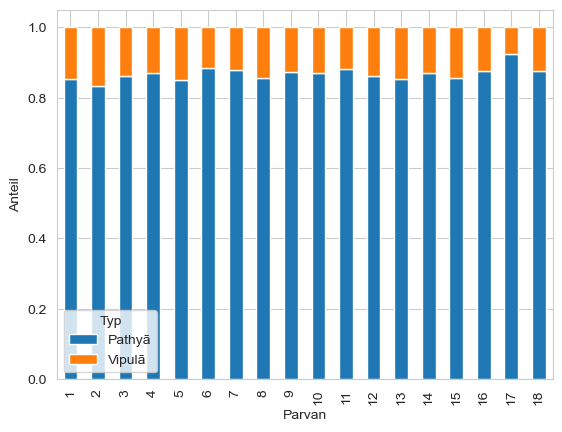

In [347]:
pd.crosstab(shlokas["Parvan"], shlokas["Typ"], normalize="index").plot.bar(stacked=True, ylabel="Anteil")

In [348]:
contingency_parvan_type = pd.crosstab(shlokas["Parvan"], shlokas["Typ"])

scipy.stats.contingency.association(contingency_parvan_type), chi2_p(contingency_parvan_type)

(0.03487174855084843, 9.986436779922493e-28)

In [349]:
shlokas["opening"] = shlokas["Quantitäten"].apply(lambda ls: ls[0:4])
shlokas["semi-cadence"] = shlokas["Quantitäten"].apply(lambda ls: ls[4:7])
shlokas["reopening"] = shlokas["Quantitäten"].apply(lambda ls: ls[8:12])
shlokas["cadence"] = shlokas["Quantitäten"].apply(lambda ls: ls[12:15])

## Welche _Vipulā_ gibt es?

In [350]:
# Vipulās
shlokas["semi-cadence"].value_counts()

LGG    122245
LLL      7351
GGG      5513
GLL      4479
GLG      1893
LGL       110
LLG        56
GGL        11
Name: semi-cadence, dtype: int64

In [351]:
# Cadence
shlokas["cadence"].value_counts()

LGL    141556
GGL       101
LLL         1
Name: cadence, dtype: int64

In [352]:
df_no_pathya = shlokas[shlokas["semi-cadence"] != "LGG"]
pd.crosstab(df_no_pathya["semi-cadence"], df_no_pathya["Parvan"]).style.background_gradient(axis="index", cmap=cm)

Parvan,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
semi-cadence,,,,,,,,,,,,,,,,,,
GGG,582,191,840,198,523,300,545,242,185,70,61,930,492,223,89,19,3,20
GGL,2,1,1,0,3,1,0,0,0,1,0,1,1,0,0,0,0,0
GLG,232,113,247,41,183,136,195,93,76,10,3,318,177,46,10,10,1,2
GLL,446,145,590,101,329,314,539,272,221,41,41,783,422,138,71,14,1,11
LGL,3,1,1,0,7,2,1,0,0,0,0,94,1,0,0,0,0,0
LLG,3,3,3,1,6,4,4,4,2,0,0,16,7,2,1,0,0,0
LLL,698,306,1060,111,586,470,688,358,361,80,71,1341,756,289,132,18,10,16


## Zusammenhänge zwischen _semi-cadence_ und _(re)opening_

In [353]:
contingency_semi_cadence_opening = pd.crosstab(shlokas["semi-cadence"], shlokas["opening"])

In [354]:
contingency_semi_cadence_opening.style.background_gradient(axis=None, cmap=cm)

opening,GGGG,GGGL,GGLG,GGLL,GLGG,GLGL,GLLG,GLLL,LGGG,LGGL,LGLG,LGLL,LLGG,LLGL,LLLG,LLLL
semi-cadence,,,,,,,,,,,,,,,,
GGG,30,3,2487,6,23,8,1,0,16,3,2918,2,8,7,1,0
GGL,1,0,4,0,1,0,0,0,0,1,2,0,1,1,0,0
GLG,328,1,516,0,201,0,2,0,219,0,588,0,36,1,1,0
GLL,139,4,1979,1,92,0,1,0,108,0,2128,0,24,2,1,0
LGG,15180,9321,6418,8787,19062,11664,5,6,12438,8336,6771,7312,11310,5631,2,2
LGL,4,1,2,1,0,0,0,0,1,0,98,1,2,0,0,0
LLG,18,1,6,1,8,1,0,0,6,2,5,3,5,0,0,0
LLL,1539,3,814,0,1989,0,0,0,1271,0,844,0,891,0,0,0


In [355]:
scipy.stats.contingency.association(contingency_semi_cadence_opening), chi2_p(contingency_semi_cadence_opening)

(0.23109316137405628, 0.0)

In [356]:
contingency_semi_cadence_reopening = pd.crosstab(shlokas["semi-cadence"], shlokas["reopening"])

In [357]:
contingency_semi_cadence_reopening.style.background_gradient(axis=None, cmap=cm)

reopening,GGGG,GGGL,GGLG,GGLL,GLGG,GLGL,GLLG,GLLL,LGGG,LGGL,LGLG,LGLL,LLGG,LLGL,LLLG,LLLL
semi-cadence,,,,,,,,,,,,,,,,
GGG,790,618,1,442,934,545,0,0,667,458,1,289,495,273,0,0
GGL,3,3,0,1,0,0,0,0,1,0,0,1,1,1,0,0
GLG,317,193,1,138,318,175,0,0,228,145,0,112,173,93,0,0
GLL,703,429,1,372,765,442,0,0,477,400,0,247,423,220,0,0
LGG,17178,12469,12,10356,20674,12777,1,5,13469,9781,22,6961,12174,6363,2,1
LGL,5,1,0,1,2,0,0,0,5,16,78,0,2,0,0,0
LLG,14,2,0,4,10,0,0,0,13,2,0,5,5,1,0,0
LLL,1103,749,0,632,1261,752,0,0,824,562,0,432,676,360,0,0


In [358]:
scipy.stats.contingency.association(contingency_semi_cadence_reopening), chi2_p(contingency_semi_cadence_reopening)

(0.27986558493409697, 0.0)

In [359]:
contingency_opening_reopening = pd.crosstab(shlokas["opening"], shlokas["reopening"])

In [360]:
contingency_opening_reopening.style.background_gradient(axis=None, cmap=cm)

reopening,GGGG,GGGL,GGLG,GGLL,GLGG,GLGL,GLLG,GLLL,LGGG,LGGL,LGLG,LGLL,LLGG,LLGL,LLLG,LLLL
opening,,,,,,,,,,,,,,,,
GGGG,2740,1774,1,1455,2868,1700,0,2,2030,1303,1,915,1615,834,1,0
GGGL,1381,962,0,838,1543,952,0,1,1102,737,2,526,858,432,0,0
GGLG,1782,1279,4,946,2041,1211,0,0,1391,980,2,658,1317,614,1,0
GGLL,1142,870,1,794,1531,936,0,0,954,724,3,488,886,467,0,0
GLGG,3018,2227,5,1830,3673,2277,1,1,2267,1621,5,1231,2107,1113,0,0
GLGL,1585,1197,0,957,1953,1277,0,0,1239,986,1,693,1167,618,0,0
GLLG,2,0,0,0,2,0,0,0,2,2,0,1,0,0,0,0
GLLL,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0
LGGG,2075,1437,1,1156,2425,1454,0,0,1591,1063,2,747,1380,728,0,0


In [361]:
scipy.stats.contingency.association(contingency_opening_reopening), chi2_p(contingency_opening_reopening)

(0.022004715122103145, 5.384541206103315e-103)

# Einzelne _akṣara_ im Vers

In [362]:
shlokas["tmp_syllables"] = shlokas["Quantitäten"].apply(lambda x: list(enumerate(x, start=1)))
silbenweise = shlokas.explode("tmp_syllables")
silbenweise["Position"] = silbenweise["tmp_syllables"].apply(lambda x: x[0])
silbenweise["Quantität"] = silbenweise["tmp_syllables"].apply(lambda x: x[1])
shlokas.drop(columns="tmp_syllables", inplace=True)

In [363]:
pd.crosstab(silbenweise["Quantität"], silbenweise["Position"]).style.background_gradient(axis="columns", cmap=cm)

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Quantität,,,,,,,,,,,,,,,,
G,80659,90668,99942,90545,11896,127879,129707,97887,85199,81734,121540,73829,101,141657,0,54236
L,60999,50990,41716,51113,129762,13779,11951,43771,56459,59924,20118,67829,141557,1,141658,87422


In [364]:
contingency_position_quantity = pd.crosstab(
    silbenweise["Position"], 
    silbenweise["Quantität"]
)
scipy.stats.contingency.association(contingency_position_quantity), chi2_p(contingency_position_quantity)

(0.6107195337733208, 0.0)

In [365]:
nur_guru = silbenweise[silbenweise["Quantität"] == "G"]

In [366]:
pd.crosstab(
    nur_guru["semi-cadence"], 
    nur_guru["Position"]
).sort_values(14, ascending=False).style.background_gradient(axis="columns", cmap=cm)

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16
semi-cadence,,,,,,,,,,,,,,,
LGG,70443,74563,92942,71186,0,122245,122245,81601,73472,70248,104885,63532,92,122244,46673
LLL,4345,4471,5693,7348,0,0,0,6975,4497,4302,6287,3864,0,7351,2862
GGG,2558,5465,98,5484,5513,5513,5513,3612,3330,3266,4780,2888,4,5513,2123
GLL,2216,4359,369,4472,4479,0,0,4107,2712,2629,3859,2369,1,4479,1778
GLG,1048,1652,786,1891,1893,0,1893,1443,1142,1134,1642,1037,4,1893,724
LGL,8,108,8,107,0,110,0,90,9,106,31,92,0,110,48
LLG,35,42,41,48,0,0,56,49,30,40,47,42,0,56,25
GGL,6,8,5,9,11,11,0,10,7,9,9,5,0,11,3


In [367]:
# no effect to be seen, also tried with .reopening and .cadence
pd.crosstab(
    nur_guru["reopening"], 
    nur_guru["Position"]
).sort_values(14, ascending=False).style.background_gradient(axis="columns", cmap=cm)

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16
reopening,,,,,,,,,,,,,,,
GLGG,13614,15370,16832,15276,2017,21610,21936,16892,23964,0,23964,23964,16,23964,9271
GGGG,11650,13062,14425,13273,1813,17976,18299,13924,20113,20113,20113,20113,30,20112,7758
LGGG,8985,10229,11063,10154,1373,14142,14377,10644,0,15684,15684,15684,16,15684,6101
GLGL,8356,9223,10402,9224,1162,13322,13497,10223,14691,0,14691,0,5,14691,5610
GGGL,8309,9141,10293,9322,1243,13091,13282,9819,14464,14464,14464,0,3,14464,5580
LLGG,7950,8966,9708,8843,1092,12672,12847,9402,0,0,13949,13949,16,13949,5286
GGLL,6820,7628,8458,7559,953,10800,10940,8168,11946,11946,0,0,6,11946,4488
LGGL,6353,7270,7909,7126,1003,10255,10386,7900,0,11364,11364,0,2,11364,4386
LGLL,4512,5046,5681,5019,649,7251,7367,5718,0,8047,0,0,7,8047,3031


In [368]:
effects = np.ndarray((16,16))

for i in range(16):
    for j in range(16):
        contingency = pd.crosstab(shlokas["Quantitäten"].str[i], shlokas["Quantitäten"].str[j])
        effects[i, j] = scipy.stats.contingency.association(contingency) if chi2_p(contingency) < SIGNIFICANCE else np.nan

In [369]:
pd.DataFrame(effects).rename(index=lambda x: x+1, columns=lambda x: x+1).style.background_gradient(axis=None, cmap=cm)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,"1,00","0,12","0,08","0,02","0,05","0,01","0,01","0,01","0,01",–,–,–,–,–,–,"0,01"
2,"0,12","1,00","0,48","0,03","0,21","0,08","0,07","0,01",–,–,–,"0,01",–,–,–,–
3,"0,08","0,48","1,00","0,03","0,40","0,15","0,13","0,04","0,01",–,–,–,–,–,–,–
4,"0,02","0,03","0,03","1,00","0,23","0,25","0,23",–,–,"0,01","0,01","0,01",–,–,–,–
5,"0,05","0,21","0,40","0,23","1,00","0,45","0,32","0,05",–,"0,01",–,–,–,–,–,–
6,"0,01","0,08","0,15","0,25","0,45","1,00","0,91","0,16",–,"0,01",–,–,–,–,–,–
7,"0,01","0,07","0,13","0,23","0,32","0,91","1,00","0,16",–,"0,01",–,–,–,–,–,–
8,"0,01","0,01","0,04",–,"0,05","0,16","0,16","1,00",–,–,–,–,–,–,–,"0,01"
9,"0,01",–,"0,01",–,–,–,–,–,"1,00","0,08",–,"0,01",–,–,–,–
10,–,–,–,"0,01","0,01","0,01","0,01",–,"0,08","1,00","0,35","0,19",–,–,–,–


In [370]:
effects_quarter = np.ndarray((4,4))
for i in range(4):
    for j in range(4):
        contingency = pd.crosstab(
            shlokas["Quantitäten"].str[(i*4):(i*4)+4],
            shlokas["Quantitäten"].str[(j*4):(j*4)+4]
        )
        effects_quarter[i, j] = scipy.stats.contingency.association(contingency) if chi2_p(contingency) < SIGNIFICANCE else np.nan

In [371]:
pd.DataFrame((effects_quarter)).rename(index=lambda x: x+1, columns=lambda x: x+1).style.background_gradient(axis=None, cmap=cm)

,1,2,3,4
1,"1,00","0,16","0,02",–
2,"0,16","1,00","0,21",–
3,"0,02","0,21","1,00",–
4,–,–,–,"1,00"


# Wortgrenzen und Zäsuren

In [372]:
def enumerate_sublists(lists):
    index = 1
    result = []
    for element in lists:
        result.append((index, element))
        index += len(element)
    return result

In [373]:
shlokas["tmp_words"] = shlokas.apply(
    lambda row: tuple(zip(
        enumerate_sublists(row["Quantitäten + Wortgrenzen"].split(".")), 
        row["Text"].split(" ")
    )), axis=1)
wortweise = shlokas.explode("tmp_words")
wortweise["Position"] = wortweise["tmp_words"].apply(lambda x: x[0][0])
wortweise["Sequenz"] = wortweise["tmp_words"].apply(lambda x: x[0][1])
wortweise["Wort"] = wortweise["tmp_words"].apply(lambda x: x[1])
shlokas.drop(columns="tmp_words", inplace=True)

In [374]:
contingency_semi_cadence_position = pd.crosstab(
    wortweise["semi-cadence"], 
    wortweise["Position"]
).sort_values(1, ascending=False)

In [375]:
contingency_semi_cadence_position.style.background_gradient(axis="columns", cmap=cm)

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
semi-cadence,,,,,,,,,,,,,,,,
LGG,122245,15768,43000,49071,45508,26313,54315,14202,122156,9746,39677,47120,47653,27332,31110,7260
LLL,7351,819,2835,1582,3169,3621,834,104,7342,542,2382,2689,2772,1569,1740,424
GGG,5513,844,1968,1614,306,5427,503,851,5516,448,1850,2111,2165,1251,1476,321
GLL,4479,748,1388,916,1321,2708,709,90,4480,323,1473,1628,1777,930,1115,204
GLG,1893,159,650,63,1831,47,152,252,1892,129,566,756,749,428,532,92
LGL,110,33,41,31,27,54,14,5,109,11,24,42,29,26,42,6
LLG,56,4,16,4,51,4,8,4,56,2,23,18,26,16,16,4
GGL,11,1,3,5,5,9,2,0,11,2,2,4,5,2,2,2


In [376]:
positions = wortweise["Position"].unique()

def word_break_at(position, qs):
    for index, sublist in enumerate_sublists(qs.split(".")):
        if index == position:
            return True
    return False

effects_break = np.zeros(positions.size)
for position in positions:
    contingency = pd.crosstab(
        shlokas["semi-cadence"],
        shlokas["Quantitäten + Wortgrenzen"].apply(lambda qs: word_break_at(position, qs))
    )
    effects_break[position-1] = scipy.stats.contingency.association(contingency) if chi2_p(contingency) < SIGNIFICANCE else np.nan
    #wortweise[wortweise["semi-cadence"] == "LLL"]["Position"].value_counts()

<AxesSubplot:xlabel='Position der Wortgrenze', ylabel='V = Einfluss der ‚semi-cadence‘'>

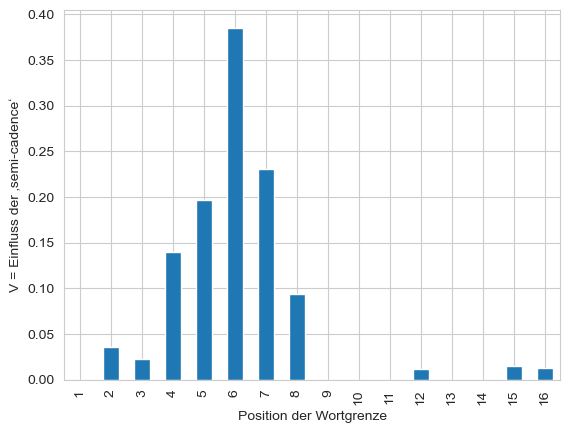

In [377]:
pd.Series(effects_break, index=range(1, 16+1)).plot.bar(xlabel="Position der Wortgrenze", ylabel="V = Einfluss der ‚semi-cadence‘")

In [378]:
contingency_sequence_position = pd.crosstab(
    wortweise["Sequenz"], 
    wortweise["Position"]
).sort_values(1, ascending=False)

In [379]:
contingency_sequence_position.head(28).style.background_gradient(axis="columns", cmap=cm)

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Sequenz,,,,,,,,,,,,,,,,
GG,18954,3404,11181,2097,1,4009,41870,0,20724,2575,11708,10,0,0,0,0
LG,15024,1877,2023,6,16203,3,1388,0,12577,1336,8,1,9434,0,14383,0
G,10459,2485,5612,3748,565,4964,1887,7127,7046,2031,4938,3737,25,3027,0,2165
GLG,8916,644,2,9143,228,39,0,0,11669,3,6,5388,0,10485,0,0
L,7562,2684,4440,4200,8918,551,56,8376,4081,1386,1737,4574,6766,0,1137,6148
GL,7006,1613,2611,5219,304,2,10793,0,5603,657,4516,5440,0,1623,0,0
GGG,6887,430,21,1,2,13434,0,1,8787,394,32,0,0,0,0,0
LGG,6556,831,1912,3,3035,22,0,1,8250,523,0,0,0,0,0,0
GLGG,5827,823,0,2420,1174,0,3,1,8734,0,0,0,0,0,0,0


In [380]:
scipy.stats.contingency.association(contingency_sequence_position), chi2_p(contingency_sequence_position)

(0.4902626235800064, 0.0)

<AxesSubplot:xlabel='Position der Wortgrenze', ylabel='Anzahl'>

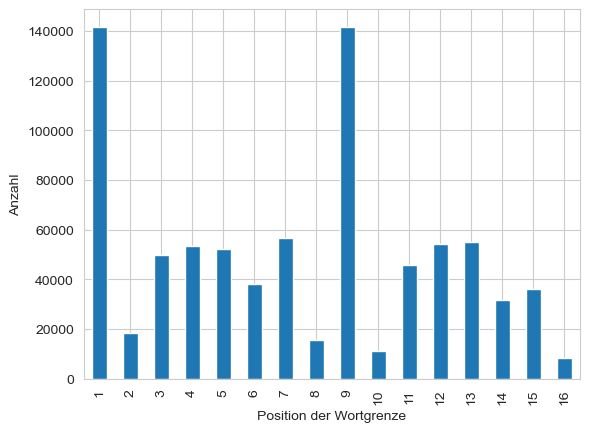

In [381]:
wortweise["Position"].value_counts().sort_index().plot.bar(xlabel="Position der Wortgrenze", ylabel="Anzahl")

In [382]:
shlokas["Quantitäten + Wortgrenzen"].apply(
    lambda qs: "_".join(str(x) for x, y in enumerate_sublists(qs.split(".")))
).value_counts()

1_4_7_9_13                 1474
1_5_9_13                   1415
1_4_7_9_12                 1292
1_5_9_12                   1277
1_3_7_9_13                  989
                           ... 
1_5_9_10_12_15_16             1
1_2_4_8_9_12_15_16            1
1_4_9_13_13                   1
1_2_3_4_8_9_10_11_12_15       1
1_5_7_9_10_11_12_13_16        1
Name: Quantitäten + Wortgrenzen, Length: 7250, dtype: int64

# Piṅgalas Verbote

In [383]:
shlokas[(shlokas.reopening.str[1:3] == "LL") | (shlokas.opening.str[1:3] == "LL")][["Stelle", "Text", "Quantitäten"]]

,Stelle,Text,Quantitäten
763,1.2.158c,adhyAyAnAM zataM proktaM saptadaza tathApare,GGGGLGGGGLLLLGLG
935,1.2.234a,etad akhilam AkhyAtaM bhArataM parvasaMgrahAt,GLLLLGGGGLGGLGLG
3225,1.39.29c,yad gRhItaM phalaM rAjJA tatra kRmir abhUd aNuH,GLGGLGGGGLLLLGLL
8125,1.99.41a,katham arAjakaM rASTraM zakyaM dhArayituM prabho,LLLGLGGGGGGLLGLG
11782,1.158.14a,na kuNapAH zRGgiNo vA na devA na ca mAnuSAH,LLLGGLGGLGGLLGLG
16497,2.10.4a,razmivatI bhAsvarA ca divyagandhA manoramA,GLLGGLGLGLGGLGLG
17240,2.19.10a,aparihAryA meghAnAM mAgadheyaM maNeH kRte,LLLGGGGGGLGGLGLG
38051,3.222.36c,nApi parivade zvazrUM sarvadA pariyantritA,GLLLLGGGGLGLLGLG
38057,3.222.39c,nApi parivade cAhaM tAM pRthAM pRthivIsamAm,GLLLLGGGGLGLLGLG
45056,4.29.26c,vayam api nigRhNImo dvidhA kRtvA varUthinIm,LLLLLGGGLGGGLGLG


In [384]:
shlokas[(shlokas.reopening.str[1:4] == "GLG")][["Stelle", "Text", "Quantitäten"]]
# Interessant auch die Verteilung auf die Parvans: ["parva"].value_counts()

,Stelle,Text,Quantitäten
19126,2.47.9a,indrakRSTair vartayanti dhAnyair nadImukhaiz c...,GLGGGLGLGGLGLGLG
22228,3.17.19c,cikSepa tarasA vIro vyAvidhya satyavikramaH,GGLLLGGGGGLGLGLL
28980,3.104.7c,vaze ca kRtvA rAjJo 'nyAn svarAjyam anvazAsata,LGLGGGGGLGLGLGLL
35195,3.188.61a,dasyuprapIDitA rAjan kAkA iva dvijottamAH,GGLGLGGGGGLGLGLG
43368,3.299.16a,hutAzanena yac cApaH pravizya channam AsatA,LGLGLGGGLGLGLGLG
...,...,...,...
144118,13.101.23a,yajJiyAnAM ca vRkSANAm ayajJiyAn nibodha me,GLGGLGGGLGLGLGLG
145130,13.109.55c,vyAdhitasyauSadhagrAmaH kruddhasya ca prasAdanam,GLGGLGGGGGLGLGLL
148807,13.151.8c,nAradaH parvataz caiva vizvAvasur hahAhuhUH,GLGGLGGLGGLGLGLG
150208,14.18.20a,ato niyamyate lokaH pramuhya dharmavartmasu,LGLGLGGGLGLGLGLL


# Moren (_mātrā_)

<AxesSubplot:xlabel='Moren', ylabel='Anzahl Verse'>

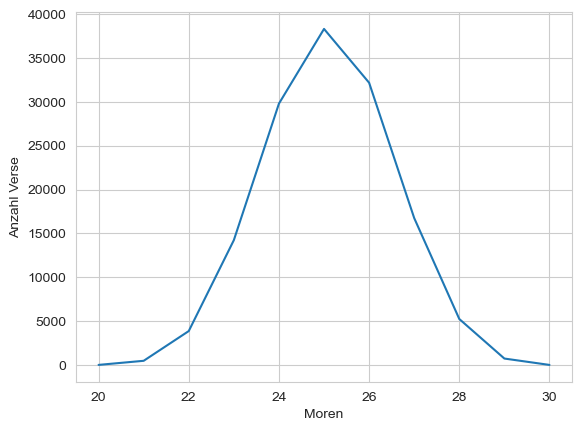

In [385]:
shlokas["Mātrās"] = shlokas["Quantitäten"].apply(lambda ls: sum(2 if c == "G" else 1 for c in ls))
shlokas["Mātrās"].value_counts().sort_index().plot.line(xlabel="Moren", ylabel="Anzahl Verse")

In [386]:
shlokas["Mātrās"].mean(), shlokas["Mātrās"].std()

(25.088643069928985, 1.4212093459708697)

In [387]:
shlokas.sort_values(by="Mātrās")[["Stelle", "Text", "Quantitäten", "Mātrās"]]

,Stelle,Text,Quantitäten,Mātrās
99790,9.25.16a,tato yatantam aparam abhivIkSya sutaM tava,LGLGLLLLLLGLLGLL,20
57872,5.154.22c,yudhiSThireNa sahita upAvizad ariMdamaH,LGLGLLLLLGLLLGLL,20
117647,12.137.31c,anRNas tena bhavati vasa pUjani mA gamaH,LLGGLLLLLLGLLGLL,20
103760,9.61.5a,gatotsavaM puram iva hRtanAgam iva hradam,LGLGLLLLLLGLLGLL,20
43274,3.298.4a,mama hi bhrAtara ime sahasrazatayodhinaH,LLGGLLLGLGLLLGLL,21
...,...,...,...,...
42132,3.281.104a,vAme skandhe tu vAmorUr bhartur bAhuM nivezya sA,GGGGLGGGGGGGLGLG,29
52590,5.72.2c,nograM duryodhano vAcyaH sAmnaivainaM samAcareH,GGGGLGGGGGGGLGLG,29
154234,14.85.12a,tad dRSTvA vismayaM jagmur gAndhArAH sarva eva te,GGGGLGGGGGGGLGLG,29
49423,5.33.41c,bhoktAro vipramucyante kartA doSeNa lipyate,GGGGLGGGGGGGLGLG,29


# Metrische Instanzen einzelner Wörter

In [388]:
# How many metrical shapes do words appear in?
wortweise.groupby("Wort")["Sequenz"].nunique().value_counts()

1    153933
2      4237
Name: Sequenz, dtype: int64

In [389]:
x = wortweise[["Wort", "Sequenz", "Silben", "Text", "Quantitäten"]]
x[x["Wort"] == "SaT"]["Sequenz"].value_counts()

G    28
L    13
Name: Sequenz, dtype: int64

In [390]:
def variability(values):
    if len(values) == 1:
        return 1
    elif len(values) == 2:
        a, b = values
        return abs(a - b) / (a + b)
    else:
        raise ValueError(values)

word_frequencies = df_localisation.groupby("word")["word"].count()
import itertools
words_schema_dev = pd.Series({key: variability(list(y for x, y in schemas)) for key, schemas in itertools.groupby(sorted(dict(word_schema_dev).items()), key=lambda x: x[0][0])}
                            , name = "schema_dev")

NameError: name 'df_localisation' is not defined

In [ ]:
words_schema_dev.sort_values()

In [ ]:
#ax = plt.subplot(111)
#ax.scatter(word_frequencies, word_schema_dev)
df_fancy = pd.DataFrame(data=[word_frequencies, words_schema_dev]).transpose()

df_fancy["last_letter"] = df_fancy.index.map(lambda x: x[-2:])

df_fancy.sort_values(by="word").head(500).pivot_table(values="schema_dev", index="last_letter").sort_values(by="schema_dev", ascending=False).head(10)

In [ ]:
df_fancy[df_fancy.last_letter == "aT"]

dharmakṣetre kurukṣetre
